# Parameter variations
USNA Capstone HYPR NARPS

some code adapted from CAPT Stu Blair, USN

used to determine optimal parameters for design:
optimal water thickness: 1 - 10 cm
various pipe materials
target thickness: 1 - 4 cm

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Define planar source geometry
xmin = -5
xmax = 5
ymin = -5
ymax = 5
zpos = 0.01

x_dist = openmc.stats.Uniform(xmin,xmax)
y_dist = openmc.stats.Uniform(ymin,ymax)
z_dist = openmc.stats.Discrete([zpos],[1.0])

plan_dist = openmc.stats.CartesianIndependent(x_dist,y_dist,z_dist)
angle_dist = openmc.stats.Monodirectional((0.0,0.0,1.0))

In [3]:
# define settings
settings = openmc.Settings() # create openmc settings object
energy = openmc.stats.Watt() # create energy spectrum of particles
settings.source = openmc.Source(space=plan_dist, energy=energy, angle=angle_dist)
settings.run_mode = 'fixed source'
settings.batches = 200
settings.particles = 500000
settings.generations_per_batch = 1

settings.export_to_xml()

In [4]:
# define materials

water = openmc.Material(name='water')
water.set_density('g/cc',0.989) # density of water at 320K (steady state operating temp of TRIGA)
water.add_element('H',2.0)
water.add_element('O',1.0)
water.add_s_alpha_beta('c_H_in_H2O')

pipe = openmc.Material(name = 'steel') # 304L Stainless steel from PNNL material Compendium
pipe.set_density('g/cc', 8.0)
pipe.add_element('C',0.000687)
pipe.add_element('Si',0.009793)
pipe.add_element('P',0.000408)
pipe.add_element('S',0.000257)
pipe.add_element('Cr',0.201015)
pipe.add_element('Mn',0.010013)
pipe.add_element('Fe',0.684101)
pipe.add_element('Ni',0.093725)


target = openmc.Material(name='target')
target.set_density('g/cc', 0.432)
target.add_nuclide('Np237', 1.0)
target.add_element('H', 1.0)
target.add_element('N', 1.0)
target.add_element('O', 3.0)

# add trace amount of Np238 and Pu238 so depletion works...
target.add_nuclide('Np238',1e-8)
target.add_nuclide('Pu238',1e-8)

target.depletable = True

In [5]:
# create geometry

length = 50 # cm
width = 10
height = 10
box = openmc.model.RectangularParallelepiped(-width/2., width/2.,
                                             -height/2., height/2.0,
                                             0., length, boundary_type='vacuum')  

#r1 = 35
#r2 = 35.23
#r3 = 36.23
#r4 = 40.23
#r5 = 41.23

r1 = 25
r2 = 35
r3 = 35.5
r4 = 40.5
r5 = 41

wwall = openmc.ZPlane(z0 = r1) # wall for water gap between rx and pipe
piwall1 = openmc.ZPlane(z0 = r2) # plane at inner pipe wall
piwall2 = openmc.ZPlane(z0 = r3) 
powall1 = openmc.ZPlane(z0 = r4) 
powall2 = openmc.ZPlane(z0 = r5) 

c1 = openmc.Cell()
c1.region = -box & -wwall
c1.fill = None

c2 = openmc.Cell()
c2.region = -box & +wwall & -piwall1
c2.fill = water

c3 = openmc.Cell()
c3.region = -box & +piwall1 & -piwall2
c3.fill = pipe

c4 = openmc.Cell()
c4.region = -box & +piwall2 & -powall1
c4.fill = target

c5 = openmc.Cell()
c5.region = -box & +powall1 & -powall2
c5.fill = pipe

c6 = openmc.Cell()
c6.region = -box & +powall2
c6.fill = water

root_univ = openmc.Universe()
root_univ.add_cells([c1,c2,c3,c4,c5,c6])

geometry = openmc.Geometry()
geometry.root_universe = root_univ
geometry.export_to_xml()


target.volume = width*height*(r4 - r3); # compute volume of target material for depletion.

materials = openmc.Materials([water, pipe, target])
materials.export_to_xml()

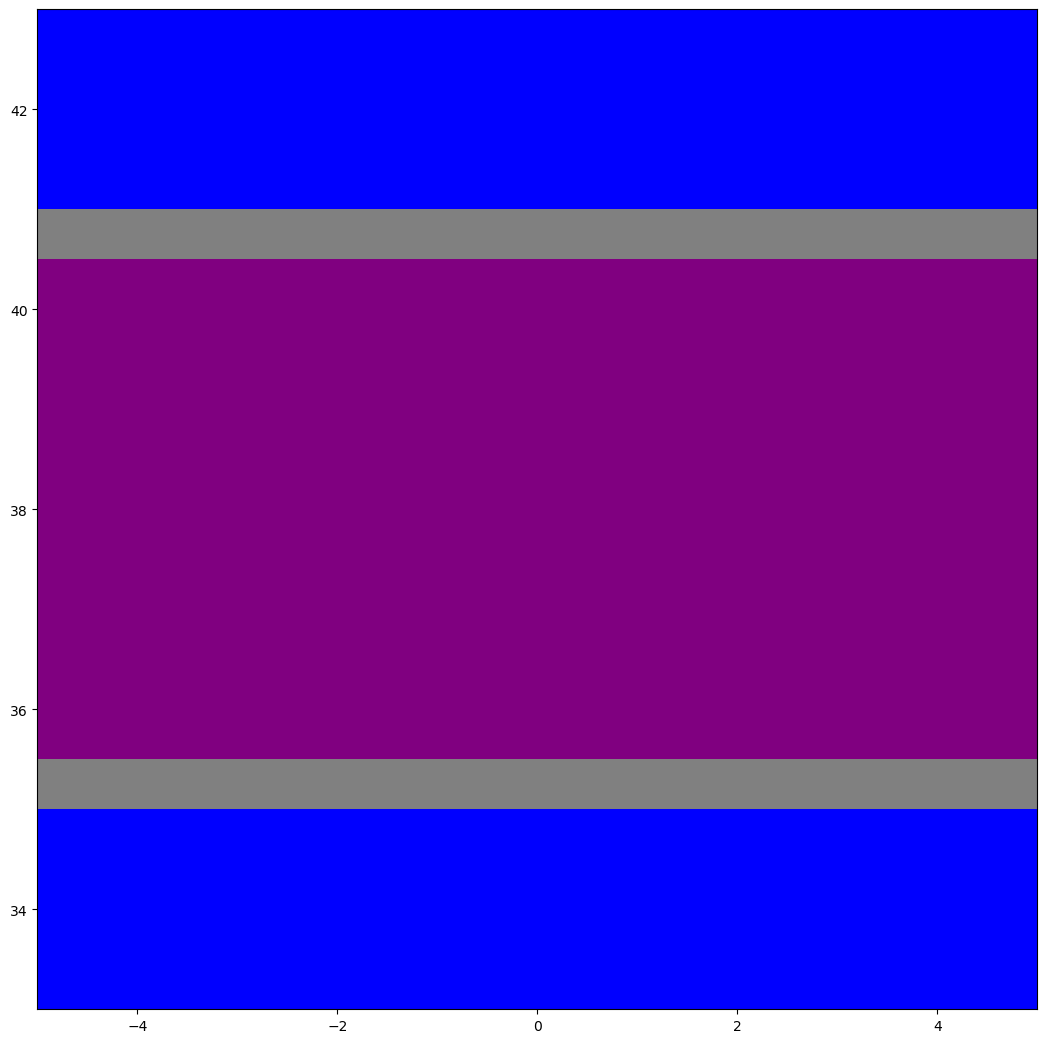

In [6]:
# plot root universe

colors = {}
colors[water]='blue'
colors[pipe]='gray'
colors[target]='purple'
root_univ.plot(origin=(0,0,38),width=(width,10),
               pixels=(1000,1000),color_by='material',
               basis='yz',colors=colors)

In [7]:
# create tallies

cell_filter = openmc.CellFilter(c4); # measure in the target material cell


# energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish a flux tally for the target
flux_target = openmc.Tally(name='flux in target');
flux_target.scores = ['flux'];
flux_target.filters = [cell_filter,energy_filter];

# create a tally to estimate rate of conversion of Np-237 to Np-238
np237_capture_t = openmc.Tally(name='Np237_total_capture');
np237_capture_t.scores = ['(n,gamma)'];
np237_capture_t.nuclides=['Np237'];
efilter_values = [0.0, 1.0, 3.0e4, 14.0e6]; #OpenMC energy units are in eV
efilter_capture = openmc.EnergyFilter(values=efilter_values);
np237_capture_t.filters = [cell_filter,efilter_capture]

# tally fission in Np238
np238_fission_t = openmc.Tally(name='Np238_fiss')
np238_fission_t.scores = ['fission']
np238_fission_t.nuclides = ['Np238']
np238_fission_t.filters = [cell_filter,efilter_capture]

# tally (n,2n) in Np237
np237_n2n_t = openmc.Tally(name='Np237_n2n')
np237_n2n_t.scores = ['(n,2n)']
np237_n2n_t.nuclides = ['Np237']
np237_n2n_t.filters = [cell_filter]

# tally fission in Np237
np237_fission_t = openmc.Tally(name='Np237_fiss')
np237_fission_t.scores = ['fission']
np237_fission_t.nuclides = ['Np237']
np237_fission_t.filters = [cell_filter]


# tally fission in Pu-238
pu238_fission_t = openmc.Tally(name='Pu238_fiss')
pu238_fission_t.scores = ['fission']
pu238_fission_t.nuclides = ['Pu238']
pu238_fission_t.filters = [cell_filter]

# tally (n,gamma) in Pu-238
pu238_capture_t = openmc.Tally(name='Pu238_capture')
pu238_capture_t.scores = ['(n,gamma)']
pu238_capture_t.nuclides = ['Pu238']
pu238_capture_t.filters = [cell_filter]

# tally "total nuclear heating"
heating_t = openmc.Tally(name='heating_t')
heating_t.scores=['heating']
heating_t.filters = [cell_filter]

# tally kappa-fission
kappa_fission_t = openmc.Tally(name='kappa_fission_t')
kappa_fission_t.scores = ['kappa-fission']
kappa_fission_t.filters = [cell_filter]

tallies = openmc.Tallies([ flux_target, np237_capture_t, np237_n2n_t,
                         np238_fission_t, pu238_fission_t, pu238_capture_t,
                         heating_t, kappa_fission_t,np237_fission_t]);
#tallies = openmc.Tallies([ flux_target, np237_capture_t, np237_n2n_t]);
tallies.export_to_xml()

In [8]:
model = openmc.model.Model(geometry,materials,settings,tallies)
operator = openmc.deplete.CoupledOperator(model,chain_file="chain_endfb71_pwr.xml",
                                         normalization_mode='source-rate');

# Assume a flux of 1e14 n/cm^2-s
avg_flux = 1.0e15; # n/cm^2-s
source_rate = height*width*avg_flux; # n/s
days = 24*3600;
time_steps = [0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.5*days, 0.5*days,
              1.0*days, 1.0*days, 1.0*days, 1.0*days, 4.0*days, 4.0*days, 
              4.0*days, 4.0*days,4.0*days, 4*days, 4*days, 4*days,4*days,
             30*days, 30*days, 180*days, 180*days, 365*days];

cecm = openmc.deplete.PredictorIntegrator(operator,time_steps,
                                    source_rates=source_rate);


repeat_depletion = True;

if(repeat_depletion):
    cecm.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Na23 from /home/m231326/omc_data/endfb71_hdf5/Na23.h5
 Reading Mg24 from /home/m231326/omc_data/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/m231326/omc_data/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/m231326/omc_data/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/m231326/omc_data/endfb71_hdf5/Al27.h5
 Reading Cl35 from /home/m231326/omc_data/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/m231326/omc_data/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/m231326/omc_data/endfb71_hdf5/Ar36.h5
 Reading Ar38 from /home/m231326/omc_data/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/m231326/omc_data/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/m231326/omc_data/endfb71_hdf5/K39.h5
 Reading K40 from /home/m231326/omc_data/endfb71_hdf5/K40.h5
 Reading K41 from /home/m231326/omc_data/endfb71_hdf5/K41.h5


 Reading Ca40 from /home/m231326/omc_data/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/m231326/omc_data/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/m231326/omc_data/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/m231326/omc_data/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/m231326/omc_data/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/m231326/omc_data/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/m231326/omc_data/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/m231326/omc_data/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/m231326/omc_data/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/m231326/omc_data/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/m231326/omc_data/endfb71_hdf5/Ti49.h5
 Reading Ti50 from /home/m231326/omc_data/endfb71_hdf5/Ti50.h5
 Reading V50 from /home/m231326/omc_data/endfb71_hdf5/V50.h5
 Reading V51 from /home/m231326/omc_data/endfb71_hdf5/V51.h5
 Reading Co58 from /home/m231326/omc_data/endfb71_hdf5/Co58.h5
 Reading Co58_m1 from /home/m231326/omc_data/endfb71_hdf5/C

 Reading Se80 from /home/m231326/omc_data/endfb71_hdf5/Se80.h5
 Reading Se82 from /home/m231326/omc_data/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/m231326/omc_data/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/m231326/omc_data/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/m231326/omc_data/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/m231326/omc_data/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/m231326/omc_data/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/m231326/omc_data/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/m231326/omc_data/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/m231326/omc_data/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/m231326/omc_data/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/m231326/omc_data/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/m231326/omc_data/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/m231326/omc_data/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/m231326/omc_data/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/m231326/omc_data/endfb71_hdf5/

 Reading Mo96 from /home/m231326/omc_data/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/m231326/omc_data/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/m231326/omc_data/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/m231326/omc_data/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/m231326/omc_data/endfb71_hdf5/Mo100.h5


 Reading Tc99 from /home/m231326/omc_data/endfb71_hdf5/Tc99.h5
 Reading Ru96 from /home/m231326/omc_data/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/m231326/omc_data/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/m231326/omc_data/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/m231326/omc_data/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/m231326/omc_data/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/m231326/omc_data/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/m231326/omc_data/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/m231326/omc_data/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/m231326/omc_data/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/m231326/omc_data/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/m231326/omc_data/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/m231326/omc_data/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/m231326/omc_data/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/m231326/omc_data/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/m231326

          1200K
          2500K


 Reading Cd108 from /home/m231326/omc_data/endfb71_hdf5/Cd108.h5
 Reading Cd110 from /home/m231326/omc_data/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/m231326/omc_data/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/m231326/omc_data/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/m231326/omc_data/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/m231326/omc_data/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/m231326/omc_data/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/m231326/omc_data/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/m231326/omc_data/endfb71_hdf5/In113.h5
 Reading In115 from /home/m231326/omc_data/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/m231326/omc_data/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/m231326/omc_data/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/m231326/omc_data/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/m231326/omc_data/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/m231326/omc_data/endfb71_hdf5/Sn116.h5
 Reading Sn117 from

          1200K
          2500K


 Reading Sn126 from /home/m231326/omc_data/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/m231326/omc_data/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/m231326/omc_data/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/m231326/omc_data/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/m231326/omc_data/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/m231326/omc_data/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/m231326/omc_data/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/m231326/omc_data/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/m231326/omc_data/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/m231326/omc_data/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/m231326/omc_data/endfb71_hdf5/Te125.h5


          1200K
          2500K


 Reading Te126 from /home/m231326/omc_data/endfb71_hdf5/Te126.h5
 Reading Te127_m1 from /home/m231326/omc_data/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/m231326/omc_data/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/m231326/omc_data/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/m231326/omc_data/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/m231326/omc_data/endfb71_hdf5/Te132.h5
 Reading I127 from /home/m231326/omc_data/endfb71_hdf5/I127.h5
 Reading I129 from /home/m231326/omc_data/endfb71_hdf5/I129.h5
 Reading I130 from /home/m231326/omc_data/endfb71_hdf5/I130.h5
 Reading I131 from /home/m231326/omc_data/endfb71_hdf5/I131.h5
 Reading I135 from /home/m231326/omc_data/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/m231326/omc_data/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/m231326/omc_data/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/m231326/omc_data/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/m231326/omc_data/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/m231326/omc_data/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/m231326/omc_data/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/m231326/omc_data/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/m231326/omc_data/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/m231326/omc_data/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/m231326/omc_data/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/m231326/omc_data/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/m231326/omc_data/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/m231326/omc_data/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/m231326/omc_data/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/m231326/omc_data/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/m231326/omc_data/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/m231326/omc_data/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/m231326/omc_data/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/m231326/omc_data/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/m231326/omc_data/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/m231326/omc_data/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/m231326/omc_data/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/m231326/omc_data/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/m231326/omc_data/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/m231326/omc_data/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/m231326/omc_data/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/m231326/omc_data/endfb71_hdf5/La138.h5
 Reading La139 from /home/m231326/omc_data/endfb71_hdf5/La139.h5
 Reading La140 from /home/m231326/omc_data/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/m231326/omc_data/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/m231326/omc_data/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/m231326/omc_data/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/m231326/omc_data/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/m231326/omc_data/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/m231326/omc_data/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home

          1200K
          2500K


 Reading Gd152 from /home/m231326/omc_data/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/m231326/omc_data/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/m231326/omc_data/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/m231326/omc_data/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/m231326/omc_data/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/m231326/omc_data/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/m231326/omc_data/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/m231326/omc_data/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/m231326/omc_data/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/m231326/omc_data/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/m231326/omc_data/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/m231326/omc_data/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/m231326/omc_data/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/m231326/omc_data/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/m231326/omc_data/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home

 Reading Bk249 from /home/m231326/omc_data/endfb71_hdf5/Bk249.h5
 Reading Bk250 from /home/m231326/omc_data/endfb71_hdf5/Bk250.h5
 Reading Cf246 from /home/m231326/omc_data/endfb71_hdf5/Cf246.h5
 Reading Cf248 from /home/m231326/omc_data/endfb71_hdf5/Cf248.h5
 Reading Cf249 from /home/m231326/omc_data/endfb71_hdf5/Cf249.h5
 Reading Cf250 from /home/m231326/omc_data/endfb71_hdf5/Cf250.h5


          1200K


 Reading Cf251 from /home/m231326/omc_data/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/m231326/omc_data/endfb71_hdf5/Cf252.h5
 Reading Cf253 from /home/m231326/omc_data/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/m231326/omc_data/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/m231326/omc_data/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/m231326/omc_data/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/m231326/omc_data/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/m231326/omc_data/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/m231326/omc_data/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/m231326/omc_data/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/m231326/omc_data/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simul

 Simulating batch 97
 Simulating batch 98
 Simulating batch 99
 Simulating batch 100
 Simulating batch 101
 Simulating batch 102
 Simulating batch 103
 Simulating batch 104
 Simulating batch 105
 Simulating batch 106
 Simulating batch 107
 Simulating batch 108
 Simulating batch 109
 Simulating batch 110
 Simulating batch 111
 Simulating batch 112
 Simulating batch 113
 Simulating batch 114
 Simulating batch 115
 Simulating batch 116
 Simulating batch 117
 Simulating batch 118
 Simulating batch 119
 Simulating batch 120
 Simulating batch 121
 Simulating batch 122
 Simulating batch 123
 Simulating batch 124
 Simulating batch 125
 Simulating batch 126
 Simulating batch 127
 Simulating batch 128
 Simulating batch 129
 Simulating batch 130
 Simulating batch 131
 Simulating batch 132
 Simulating batch 133
 Simulating batch 134
 Simulating batch 135
 Simulating batch 136
 Simulating batch 137
 Simulating batch 138
 Simulating batch 139
 Simulating batch 140
 Simulating batch 141
 Simulating b

[openmc.deplete] t=64800.0 s, dt=21600.0 s, source=1e+17
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Simulating batch 11
 Simulating batch 12
 Simulating batch 13
 Simulating batch 14
 Simulating batch 15
 Simulating batch 16
 Simulating batch 17
 Simulating batch 18
 Simulating batch 19
 Simulating batch 20
 Simulating batch 21
 Simulating batch 22
 Simulating batch 23
 Simulating batch 24
 Simulating batch 25
 Simulating batch 26
 Simulating batch 27
 Simulating batch 28
 Simulating batch 29
 Simulating batch 30
 Simulating batch 31
 Simulating batch 32
 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch 39


 Simulating batch 127
 Simulating batch 128
 Simulating batch 129
 Simulating batch 130
 Simulating batch 131
 Simulating batch 132
 Simulating batch 133
 Simulating batch 134
 Simulating batch 135
 Simulating batch 136
 Simulating batch 137
 Simulating batch 138
 Simulating batch 139
 Simulating batch 140
 Simulating batch 141
 Simulating batch 142
 Simulating batch 143
 Simulating batch 144
 Simulating batch 145
 Simulating batch 146
 Simulating batch 147
 Simulating batch 148
 Simulating batch 149
 Simulating batch 150
 Simulating batch 151
 Simulating batch 152
 Simulating batch 153
 Simulating batch 154
 Simulating batch 155
 Simulating batch 156
 Simulating batch 157
 Simulating batch 158
 Simulating batch 159
 Simulating batch 160
 Simulating batch 161
 Simulating batch 162
 Simulating batch 163
 Simulating batch 164
 Simulating batch 165
 Simulating batch 166
 Simulating batch 167
 Simulating batch 168
 Simulating batch 169
 Simulating batch 170
 Simulating batch 171
 Simulatin

 Simulating batch 9
 Simulating batch 10
 Simulating batch 11
 Simulating batch 12
 Simulating batch 13
 Simulating batch 14
 Simulating batch 15
 Simulating batch 16
 Simulating batch 17
 Simulating batch 18
 Simulating batch 19
 Simulating batch 20
 Simulating batch 21
 Simulating batch 22
 Simulating batch 23
 Simulating batch 24
 Simulating batch 25
 Simulating batch 26
 Simulating batch 27
 Simulating batch 28
 Simulating batch 29
 Simulating batch 30
 Simulating batch 31
 Simulating batch 32
 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch 39
 Simulating batch 40
 Simulating batch 41
 Simulating batch 42
 Simulating batch 43
 Simulating batch 44
 Simulating batch 45
 Simulating batch 46
 Simulating batch 47
 Simulating batch 48
 Simulating batch 49
 Simulating batch 50
 Simulating batch 51
 Simulating batch 52
 Simulating batch 53
 Simulating batch 54
 Simulating batch 55
 Simulating ba

 Simulating batch 143
 Simulating batch 144
 Simulating batch 145
 Simulating batch 146
 Simulating batch 147
 Simulating batch 148
 Simulating batch 149
 Simulating batch 150
 Simulating batch 151
 Simulating batch 152
 Simulating batch 153
 Simulating batch 154
 Simulating batch 155
 Simulating batch 156
 Simulating batch 157
 Simulating batch 158
 Simulating batch 159
 Simulating batch 160
 Simulating batch 161
 Simulating batch 162
 Simulating batch 163
 Simulating batch 164
 Simulating batch 165
 Simulating batch 166
 Simulating batch 167
 Simulating batch 168
 Simulating batch 169
 Simulating batch 170
 Simulating batch 171
 Simulating batch 172
 Simulating batch 173
 Simulating batch 174
 Simulating batch 175
 Simulating batch 176
 Simulating batch 177
 Simulating batch 178
 Simulating batch 179
 Simulating batch 180
 Simulating batch 181
 Simulating batch 182
 Simulating batch 183
 Simulating batch 184
 Simulating batch 185
 Simulating batch 186
 Simulating batch 187
 Simulatin

 Simulating batch 26
 Simulating batch 27
 Simulating batch 28
 Simulating batch 29
 Simulating batch 30
 Simulating batch 31
 Simulating batch 32
 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch 39
 Simulating batch 40
 Simulating batch 41
 Simulating batch 42
 Simulating batch 43
 Simulating batch 44
 Simulating batch 45
 Simulating batch 46
 Simulating batch 47
 Simulating batch 48
 Simulating batch 49
 Simulating batch 50
 Simulating batch 51
 Simulating batch 52
 Simulating batch 53
 Simulating batch 54
 Simulating batch 55
 Simulating batch 56
 Simulating batch 57
 Simulating batch 58
 Simulating batch 59
 Simulating batch 60
 Simulating batch 61
 Simulating batch 62
 Simulating batch 63
 Simulating batch 64
 Simulating batch 65
 Simulating batch 66
 Simulating batch 67
 Simulating batch 68
 Simulating batch 69
 Simulating batch 70
 Simulating batch 71
 Simulating batch 72
 Simulating b

 Simulating batch 159
 Simulating batch 160
 Simulating batch 161
 Simulating batch 162
 Simulating batch 163
 Simulating batch 164
 Simulating batch 165
 Simulating batch 166
 Simulating batch 167
 Simulating batch 168
 Simulating batch 169
 Simulating batch 170
 Simulating batch 171
 Simulating batch 172
 Simulating batch 173
 Simulating batch 174
 Simulating batch 175
 Simulating batch 176
 Simulating batch 177
 Simulating batch 178
 Simulating batch 179
 Simulating batch 180
 Simulating batch 181
 Simulating batch 182
 Simulating batch 183
 Simulating batch 184
 Simulating batch 185
 Simulating batch 186
 Simulating batch 187
 Simulating batch 188
 Simulating batch 189
 Simulating batch 190
 Simulating batch 191
 Simulating batch 192
 Simulating batch 193
 Simulating batch 194
 Simulating batch 195
 Simulating batch 196
 Simulating batch 197
 Simulating batch 198
 Simulating batch 199
 Simulating batch 200
 Creating state point statepoint.200.h5...

 =======================>     TI

 Simulating batch 43
 Simulating batch 44
 Simulating batch 45
 Simulating batch 46
 Simulating batch 47
 Simulating batch 48
 Simulating batch 49
 Simulating batch 50
 Simulating batch 51
 Simulating batch 52
 Simulating batch 53
 Simulating batch 54
 Simulating batch 55
 Simulating batch 56
 Simulating batch 57
 Simulating batch 58
 Simulating batch 59
 Simulating batch 60
 Simulating batch 61
 Simulating batch 62
 Simulating batch 63
 Simulating batch 64
 Simulating batch 65
 Simulating batch 66
 Simulating batch 67
 Simulating batch 68
 Simulating batch 69
 Simulating batch 70
 Simulating batch 71
 Simulating batch 72
 Simulating batch 73
 Simulating batch 74
 Simulating batch 75
 Simulating batch 76
 Simulating batch 77
 Simulating batch 78
 Simulating batch 79
 Simulating batch 80
 Simulating batch 81
 Simulating batch 82
 Simulating batch 83
 Simulating batch 84
 Simulating batch 85
 Simulating batch 86
 Simulating batch 87
 Simulating batch 88
 Simulating batch 89
 Simulating b

 Simulating batch 175
 Simulating batch 176
 Simulating batch 177
 Simulating batch 178
 Simulating batch 179
 Simulating batch 180
 Simulating batch 181
 Simulating batch 182
 Simulating batch 183
 Simulating batch 184
 Simulating batch 185
 Simulating batch 186
 Simulating batch 187
 Simulating batch 188
 Simulating batch 189
 Simulating batch 190
 Simulating batch 191
 Simulating batch 192
 Simulating batch 193
 Simulating batch 194
 Simulating batch 195
 Simulating batch 196
 Simulating batch 197
 Simulating batch 198
 Simulating batch 199
 Simulating batch 200
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.3931e+02 seconds
   Time in transport only          = 2.3919e+02 seconds
   Time in active batches          = 2.3931e+02 seconds
   Time accumulating talli

 Simulating batch 59
 Simulating batch 60
 Simulating batch 61
 Simulating batch 62
 Simulating batch 63
 Simulating batch 64
 Simulating batch 65
 Simulating batch 66
 Simulating batch 67
 Simulating batch 68
 Simulating batch 69
 Simulating batch 70
 Simulating batch 71
 Simulating batch 72
 Simulating batch 73
 Simulating batch 74
 Simulating batch 75
 Simulating batch 76
 Simulating batch 77
 Simulating batch 78
 Simulating batch 79
 Simulating batch 80
 Simulating batch 81
 Simulating batch 82
 Simulating batch 83
 Simulating batch 84
 Simulating batch 85
 Simulating batch 86
 Simulating batch 87
 Simulating batch 88
 Simulating batch 89
 Simulating batch 90
 Simulating batch 91
 Simulating batch 92
 Simulating batch 93
 Simulating batch 94
 Simulating batch 95
 Simulating batch 96
 Simulating batch 97
 Simulating batch 98
 Simulating batch 99
 Simulating batch 100
 Simulating batch 101
 Simulating batch 102
 Simulating batch 103
 Simulating batch 104
 Simulating batch 105
 Simula

 Simulating batch 190
 Simulating batch 191
 Simulating batch 192
 Simulating batch 193
 Simulating batch 194
 Simulating batch 195
 Simulating batch 196
 Simulating batch 197
 Simulating batch 198
 Simulating batch 199
 Simulating batch 200
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.5046e+02 seconds
   Time in transport only          = 2.4910e+02 seconds
   Time in active batches          = 2.5046e+02 seconds
   Time accumulating tallies       = 1.3250e+00 seconds
   Time writing statepoints        = 2.0476e-02 seconds
 Total time for finalization       = 1.5482e-03 seconds
 Total time elapsed                = 2.5092e+02 seconds
 Calculation Rate (active)         = 399265 particles/second

 ============================>     RESULTS     <======================

 Simulating batch 75
 Simulating batch 76
 Simulating batch 77
 Simulating batch 78
 Simulating batch 79
 Simulating batch 80
 Simulating batch 81
 Simulating batch 82
 Simulating batch 83
 Simulating batch 84
 Simulating batch 85
 Simulating batch 86
 Simulating batch 87
 Simulating batch 88
 Simulating batch 89
 Simulating batch 90
 Simulating batch 91
 Simulating batch 92
 Simulating batch 93
 Simulating batch 94
 Simulating batch 95
 Simulating batch 96
 Simulating batch 97
 Simulating batch 98
 Simulating batch 99
 Simulating batch 100
 Simulating batch 101
 Simulating batch 102
 Simulating batch 103
 Simulating batch 104
 Simulating batch 105
 Simulating batch 106
 Simulating batch 107
 Simulating batch 108
 Simulating batch 109
 Simulating batch 110
 Simulating batch 111
 Simulating batch 112
 Simulating batch 113
 Simulating batch 114
 Simulating batch 115
 Simulating batch 116
 Simulating batch 117
 Simulating batch 118
 Simulating batch 119
 Simulating batch 120
 Simulating b

[openmc.deplete] t=6220800.0 s, dt=2592000.0 s, source=1e+17
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Simulating batch 11
 Simulating batch 12
 Simulating batch 13
 Simulating batch 14
 Simulating batch 15
 Simulating batch 16
 Simulating batch 17
 Simulating batch 18
 Simulating batch 19
 Simulating batch 20
 Simulating batch 21
 Simulating batch 22
 Simulating batch 23
 Simulating batch 24
 Simulating batch 25
 Simulating batch 26
 Simulating batch 27
 Simulating batch 28
 Simulating batch 29
 Simulating batch 30
 Simulating batch 31
 Simulating batch 32
 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch

 Simulating batch 127
 Simulating batch 128
 Simulating batch 129
 Simulating batch 130
 Simulating batch 131
 Simulating batch 132
 Simulating batch 133
 Simulating batch 134
 Simulating batch 135
 Simulating batch 136
 Simulating batch 137
 Simulating batch 138
 Simulating batch 139
 Simulating batch 140
 Simulating batch 141
 Simulating batch 142
 Simulating batch 143
 Simulating batch 144
 Simulating batch 145
 Simulating batch 146
 Simulating batch 147
 Simulating batch 148
 Simulating batch 149
 Simulating batch 150
 Simulating batch 151
 Simulating batch 152
 Simulating batch 153
 Simulating batch 154
 Simulating batch 155
 Simulating batch 156
 Simulating batch 157
 Simulating batch 158
 Simulating batch 159
 Simulating batch 160
 Simulating batch 161
 Simulating batch 162
 Simulating batch 163
 Simulating batch 164
 Simulating batch 165
 Simulating batch 166
 Simulating batch 167
 Simulating batch 168
 Simulating batch 169
 Simulating batch 170
 Simulating batch 171
 Simulatin

 Simulating batch 9
 Simulating batch 10
 Simulating batch 11
 Simulating batch 12
 Simulating batch 13
 Simulating batch 14
 Simulating batch 15
 Simulating batch 16
 Simulating batch 17
 Simulating batch 18
 Simulating batch 19
 Simulating batch 20
 Simulating batch 21
 Simulating batch 22
 Simulating batch 23
 Simulating batch 24
 Simulating batch 25
 Simulating batch 26
 Simulating batch 27
 Simulating batch 28
 Simulating batch 29
 Simulating batch 30
 Simulating batch 31
 Simulating batch 32
 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch 39
 Simulating batch 40
 Simulating batch 41
 Simulating batch 42
 Simulating batch 43
 Simulating batch 44
 Simulating batch 45
 Simulating batch 46
 Simulating batch 47
 Simulating batch 48
 Simulating batch 49
 Simulating batch 50
 Simulating batch 51
 Simulating batch 52
 Simulating batch 53
 Simulating batch 54
 Simulating batch 55
 Simulating ba

 Simulating batch 139
 Simulating batch 140
 Simulating batch 141
 Simulating batch 142
 Simulating batch 143
 Simulating batch 144
 Simulating batch 145
 Simulating batch 146
 Simulating batch 147
 Simulating batch 148
 Simulating batch 149
 Simulating batch 150
 Simulating batch 151
 Simulating batch 152
 Simulating batch 153
 Simulating batch 154
 Simulating batch 155
 Simulating batch 156
 Simulating batch 157
 Simulating batch 158
 Simulating batch 159
 Simulating batch 160
 Simulating batch 161
 Simulating batch 162
 Simulating batch 163
 Simulating batch 164
 Simulating batch 165
 Simulating batch 166
 Simulating batch 167
 Simulating batch 168
 Simulating batch 169
 Simulating batch 170
 Simulating batch 171
 Simulating batch 172
 Simulating batch 173
 Simulating batch 174
 Simulating batch 175
 Simulating batch 176
 Simulating batch 177
 Simulating batch 178
 Simulating batch 179
 Simulating batch 180
 Simulating batch 181
 Simulating batch 182
 Simulating batch 183
 Simulatin

In [9]:
results = openmc.deplete.Results('./depletion_results.h5')

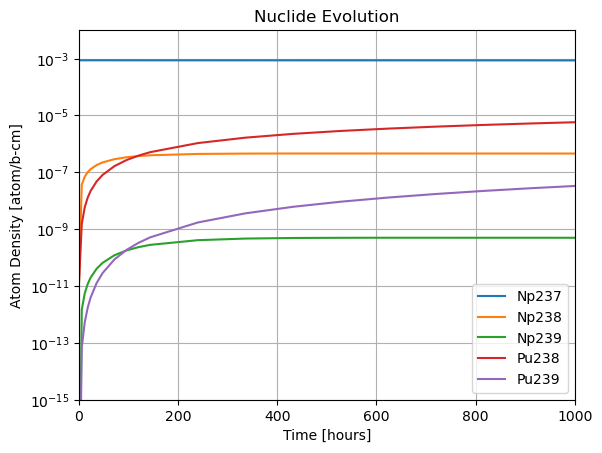

In [10]:
# check the materials.xml file to get the material number for the target
time, np237 = results.get_atoms("3","Np237",nuc_units="atom/b-cm",
                               time_units="h")
time, np238 = results.get_atoms("3","Np238",nuc_units="atom/b-cm",
                               time_units="h")
time, np239 = results.get_atoms("3","Np239",nuc_units="atom/b-cm",
                               time_units="h")
time, pu238 = results.get_atoms("3","Pu238",nuc_units="atom/b-cm",
                                time_units="h")
time, pu239 = results.get_atoms("3","Pu239",nuc_units="atom/b-cm",
                               time_units="h")

time, pu240 = results.get_atoms("3","Pu240",nuc_units="atom/b-cm",
                                time_units="h")
time, pu241 = results.get_atoms("3","Pu241",nuc_units="atom/b-cm",
                               time_units="h")
time, pu242 = results.get_atoms("3","Pu242",nuc_units="atom/b-cm",
                               time_units="h")


plt.semilogy(time,np237,label="Np237")
plt.semilogy(time,np238,label="Np238")
plt.semilogy(time,np239,label="Np239")
plt.semilogy(time,pu238,label="Pu238")
plt.semilogy(time,pu239,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Atom Density [atom/b-cm]")
plt.grid()
plt.axis([0,1000,1e-15,1e-2])
plt.legend()

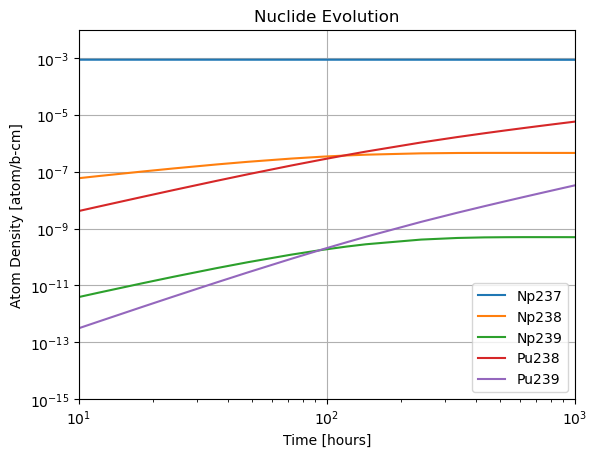

In [11]:
# repeat with loglog plot.

plt.loglog(time,np237,label="Np237")
plt.loglog(time,np238,label="Np238")
plt.loglog(time,np239,label="Np239")
plt.loglog(time,pu238,label="Pu238")
plt.loglog(time,pu239,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Atom Density [atom/b-cm]")
plt.grid()
plt.axis([10,1000,1e-15,1e-2])
plt.legend()

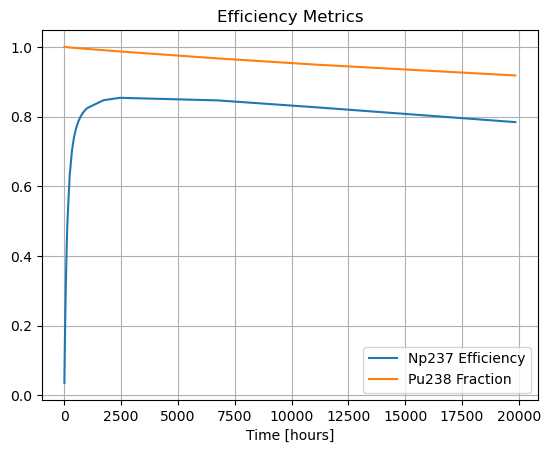

In [12]:
# plot cumulative increase of Pu-238 / cumulative use of Np-237 (metric1)
# and ratio of Pu-238 / all Pu (metric2)

change_np237 = np237[0] - np237[1:]
change_pu238 = pu238[1:] - pu238[0]
metric1 = change_pu238/change_np237

allPu = pu238 + pu239 + pu240 + pu241 + pu242

metric2 = pu238[1:]/allPu[1:]

plt.plot(time[1:],metric1,label="Np237 Efficiency")
plt.plot(time[1:],metric2,label="Pu238 Fraction")
plt.title("Efficiency Metrics")
plt.xlabel("Time [hours]")
plt.grid()
plt.legend()

In [13]:
times, np237_abs_rates = results.get_reaction_rate('3','Np237','(n,gamma)')
times, np237_fiss_rates = results.get_reaction_rate('3','Np237','fission')
times, np237_n2n_rates = results.get_reaction_rate('3','Np237','(n,2n)')

In [14]:
nSteps = 25; # number of burnup steps
# make arrays to hold reaction rate tally data

np238f = np.zeros([nSteps,],dtype=np.float64);
np237n2n = np.zeros_like(np238f);
pu238f = np.zeros_like(np238f);
pu238c = np.zeros_like(np238f);

nuc_heating = np.zeros_like(np238f);
kappa_fission = np.zeros_like(np238f);

np237f = np.zeros_like(np238f);

eV_to_kJ = 1.60218e-22; # convert eV to kJ


name_stub = "openmc_simulation_n";
name_suffix = ".h5"

# populate the arrays
for n in range(nSteps):
    fn = name_stub + str(n) + name_suffix # assemble the filename
    sp = openmc.StatePoint(fn); # open the statepoint file
    
    # read the tallies and populate associated numpy arrays
    t1 = sp.get_tally(name="Np238_fiss");
    t1_df = t1.get_pandas_dataframe()
    np238f[n] = t1_df['mean'][0];
    
    t2 = sp.get_tally(name="Np237_n2n");
    t2_df = t2.get_pandas_dataframe();
    np237n2n[n] = t2_df['mean'][0];
    
    t3 = sp.get_tally(name="Pu238_fiss");
    t3_df = t3.get_pandas_dataframe();
    pu238f[n] = t3_df['mean'][0];
    
    t4 = sp.get_tally(name="Pu238_capture");
    t4_df = t4.get_pandas_dataframe();
    pu238c[n] = t4_df['mean'][0];
    
    t5 = sp.get_tally(name="heating_t");
    t5_df = t5.get_pandas_dataframe();
    nuc_heating[n] = t5_df['mean'][0]*source_rate*eV_to_kJ;
    
    t6 = sp.get_tally(name="kappa_fission_t");
    t6_df = t6.get_pandas_dataframe();
    kappa_fission[n] = t6_df['mean'][0]*source_rate*eV_to_kJ;
    
    t7 = sp.get_tally(name="Np237_fiss");
    t7_df = t7.get_pandas_dataframe();
    np237f[n] = t7_df['mean'][0];
    
    sp.close(); # close the statepoint file

(0.0, 0.0009)

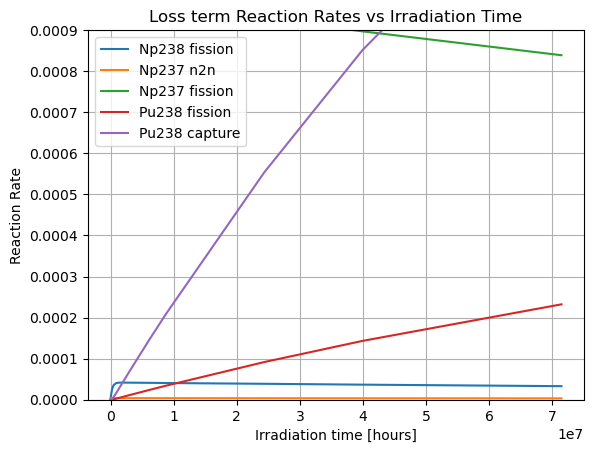

In [15]:
plt.plot(times,np238f,label='Np238 fission')
plt.plot(times,np237n2n,label='Np237 n2n');
plt.plot(times,np237f,label='Np237 fission')
plt.plot(times,pu238f,label='Pu238 fission')
plt.plot(times,pu238c, label='Pu238 capture')
plt.grid()
plt.legend()
plt.xlabel('Irradiation time [hours]')
plt.ylabel('Reaction Rate')
plt.title('Loss term Reaction Rates vs Irradiation Time');
plt.ylim([0,0.0009])

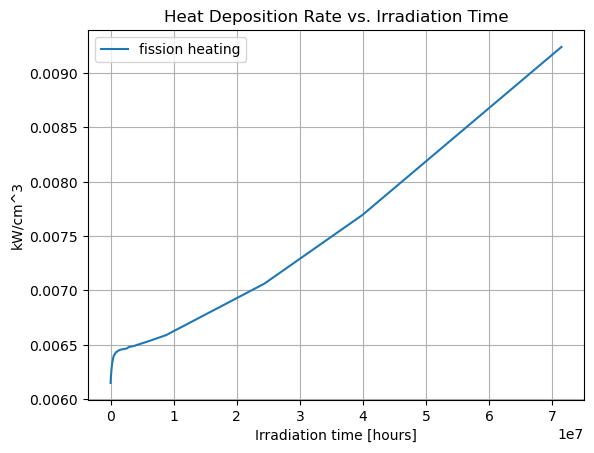

In [16]:
#plt.plot(times,nuc_heating/target.volume,label='total nuclear heating')
plt.plot(times,kappa_fission/target.volume,label='fission heating')
plt.grid()
plt.legend()
plt.xlabel('Irradiation time [hours]')
plt.ylabel('kW/cm^3')
plt.title('Heat Deposition Rate vs. Irradiation Time');

In [17]:
sp = openmc.StatePoint('openmc_simulation_n24.h5')

avg_flux = sp.get_tally(name='avg flux')
avg_flux_df = avg_flux.get_pandas_dataframe();
avg_flux_vals = avg_flux_df['mean'].to_numpy();

energy_x = 0.5*(energy_bins[0:-1] + energy_bins[1:]);

plt.loglog(energy_x,avg_flux_vals);
plt.grid();
plt.xlabel('Energy [eV]');
plt.ylabel('flux [n/cm**2-s]');

LookupError: Unable to get Tally